## Classification for DeepQL topics

In [1]:
import keras
import re
import numpy as np
import pandas as pd

import os
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
    
# %matplotlib inline

from methods.baseline import Baseline
from methods.experiments import Experiment
from methods.evaluation import Evaluation
from methods.retrieval import Retrieval

from keras.layers import Conv1D, Input, Add, Activation, Dropout, Embedding, MaxPooling1D, GlobalMaxPool1D, Flatten, Dense, Concatenate, BatchNormalization
from keras.models import Model

from keras.models import Model
from keras.layers import Input
from keras.models import load_model
import keras.backend as K
from keras_bert import get_custom_objects

import keras.backend as K
from keras_bert import load_vocabulary
from keras.layers import concatenate, Dropout, Add, Flatten
from keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import _pickle as pickle

Using TensorFlow backend.


## Configurações Globais

In [2]:
# %env epochs 1000
# %env base openoffice
# %env method deepTL_topics

env: epochs=1000
env: base=openoffice
env: method=deepTL_topics


In [3]:
EMBEDDING_DIM = 300
MAX_NB_WORDS = 2000
epochs = int(os.environ['epochs'])

In [4]:
DOMAIN = os.environ['base']
METHOD = '{}_{}'.format(os.environ['method'], epochs)
TOKEN = 'bert'
PREPROCESSING = 'bert'
DIR = 'data/processed/{}/{}'.format(DOMAIN, PREPROCESSING)
DATASET = os.path.join('data/normalized/{}'.format(DOMAIN), '{}.csv'.format(DOMAIN))
DIR_PAIRS = 'data/normalized/{}'.format(DOMAIN)
SAVE_PATH = '{}_classification({})'.format(METHOD, DOMAIN)
PRETRAINED_MODEL = 'modelos/model_{}_preprocessing_{}_feature_{}epochs_64batch({}).h5'.format(PREPROCESSING, METHOD, str(epochs), DOMAIN)
TEST_PATH = os.path.join(DIR, 'test_classification.txt')

In [5]:
print("*********")
print("{} for {} epochs in {}".format(METHOD, epochs, DOMAIN))
print("*********")

*********
deepTL_topics_1000 for 1000 epochs in openoffice
*********


In [6]:
print(PRETRAINED_MODEL)

modelos/model_bert_preprocessing_deepTL_topics_1000_feature_1000epochs_64batch(openoffice).h5


In [7]:
K.clear_session()

"""
    A lista de modelos estar disponível no diretorio /modelos
        name:
            - model_baseline_{X}epoch_{Y}steps_({dataset}).h5
            - model_baseline_{X}epoch_{Y}steps_({dataset}).json
    
        Informações adicionais:
            {X} - total de épocas treinada. Ex: 100, 1000
            {Y} - total de steps validados no treino. Ex: 10, 16
            {dataset} - Nome da base testada. Ex: Eclipse, Netbeans, OpenOffice
"""
similarity_model = load_model(PRETRAINED_MODEL, custom_objects=get_custom_objects())






Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.









/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [8]:
MAX_SEQUENCE_LENGTH_T = K.int_shape(similarity_model.input[0])[1]
MAX_SEQUENCE_LENGTH_D = K.int_shape(similarity_model.input[1])[1]
MAX_SEQUENCE_LENGTH_I = K.int_shape(similarity_model.input[4])[1]
MAX_SEQUENCE_LENGTH_TOPICS = K.int_shape(similarity_model.input[5])[1]

MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, MAX_SEQUENCE_LENGTH_I, MAX_SEQUENCE_LENGTH_TOPICS

(20, 20, 738, 30)

In [9]:
pretrained_path = 'uncased_L-12_H-768_A-12'
config_path = os.path.join(pretrained_path, 'bert_config.json')
model_path = os.path.join(pretrained_path, 'bert_model.ckpt')
vocab_path = os.path.join(pretrained_path, 'vocab.txt')

In [10]:
token_dict = load_vocabulary(vocab_path)

In [11]:
baseline = Baseline(DOMAIN, DIR, DATASET, MAX_SEQUENCE_LENGTH_T, MAX_SEQUENCE_LENGTH_D, 
                    token_dict['[CLS]'], token_dict['[SEP]'])
evaluation = Evaluation(verbose=0)
retrieval = Retrieval()
experiment = Experiment(baseline, evaluation)

In [12]:
baseline.info_dict

{'bug_severity': 6,
 'bug_status': 3,
 'component': 144,
 'priority': 5,
 'product': 41,
 'version': 539}

In [13]:
experiment.set_retrieval(retrieval, baseline, DOMAIN)

#### Loading bug ids in memory

In [14]:
experiment.load_ids()
print(len(baseline.bug_ids))

Reading bug ids
98070


#### Loading train bugs

In [15]:
%%time

experiment.load_bugs(TOKEN)


CPU times: user 17.3 s, sys: 1.18 s, total: 18.5 s
Wall time: 20.7 s


In [16]:
%%time
issues_by_buckets = experiment.get_buckets_for_bugs()
experiment.prepare_dataset(issues_by_buckets, path_train='train_chronological', path_test='test_chronological')


CPU times: user 3.13 s, sys: 58.4 ms, total: 3.19 s
Wall time: 3.47 s


In [17]:
%%time

bug_train_ids = experiment.get_train_ids(baseline.train_data)

CPU times: user 298 ms, sys: 0 ns, total: 298 ms
Wall time: 314 ms


In [18]:
print(len(bug_train_ids))

2452118


In [19]:
%%time

baseline.test_data, baseline.dup_sets_test = experiment.read_test_data_classification(DIR, baseline.bug_set, 
                                                                                      bug_train_ids,
                                                                                     path='test_chronological')

Reading test data for classification
CPU times: user 160 ms, sys: 0 ns, total: 160 ms
Wall time: 237 ms


In [20]:
bug_test_ids = experiment.get_test_ids(baseline.test_data)
print(len(bug_test_ids))

81222


In [21]:
baseline.test_data[:10]

[[16384, 16385],
 [16384, 15363],
 [16384, 16387],
 [16384, 16388],
 [16384, 14054],
 [16384, 16391],
 [16384, 16392],
 [16384, 16393],
 [16384, 16394],
 [16384, 16395]]

## Siamese  model

In [22]:
# Freeze weights
for layer in similarity_model.layers:
    layer.trainable = False

In [23]:
bug_t_a = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a')
bug_t_a_token = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_a_token')
bug_t_b = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b')
bug_t_b_token = Input(shape = (MAX_SEQUENCE_LENGTH_T, ), name = 'title_b_token')

bug_d_a = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a')
bug_d_a_token = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_a_token')
bug_d_b = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b')
bug_d_b_token = Input(shape = (MAX_SEQUENCE_LENGTH_D, ), name = 'desc_b_token')

bug_i_a = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_a')
bug_i_b = Input(shape = (MAX_SEQUENCE_LENGTH_I, ), name = 'info_b')

bug_tp_a = Input(shape = (MAX_SEQUENCE_LENGTH_TOPICS, ), name = 'topic_a')
bug_tp_b = Input(shape = (MAX_SEQUENCE_LENGTH_TOPICS, ), name = 'topic_b')

title_encoder = similarity_model.get_layer('FeatureBERTGenerationModelTitle')
desc_encoder = similarity_model.get_layer('FeatureBERTGenerationModelDescription')
info_encoder = similarity_model.get_layer('FeatureMlpGenerationModel')
topic_encoder = similarity_model.get_layer('FeatureTopicMlpGenerationModel')

model = similarity_model.get_layer('merge_features_in')

# Bug A
bugt_t_a = title_encoder([bug_t_a, bug_t_a_token])
bugt_d_a = desc_encoder([bug_d_a, bug_d_a_token])
bugt_i_a = info_encoder(bug_i_a)
bugt_tp_a = topic_encoder(bug_tp_a)
# Bug B
bugt_t_b = title_encoder([bug_t_b, bug_t_b_token])
bugt_d_b = desc_encoder([bug_d_b, bug_d_b_token])
bugt_i_b = info_encoder(bug_i_b)
bugt_tp_b = topic_encoder(bug_tp_b)

bug_a = model([bugt_i_a, bugt_t_a, bugt_d_a, bugt_tp_a])
bug_b = model([bugt_i_b, bugt_t_b, bugt_d_b, bugt_tp_b])

x = concatenate([bug_a, bug_b], name='bugs') # 

for _ in range(2):
    # propose_bert_triplet
#     x = Dense(128)(x)
#     x = Dropout(0.75)(x)
#     x = Activation('relu')(x)
#     x = BatchNormalization()(x)
    x = Dense(64)(x)
    x = Dropout(0.25)(x)
    x = Activation('tanh')(x)
    #x = BatchNormalization()(x)

output = Dense(2, activation = 'softmax', name = 'output')(x)

model_clf = Model(inputs=[bug_t_a_token, bug_t_a, bug_t_b_token, bug_t_b, 
                          bug_d_a_token, bug_d_a, bug_d_b_token, bug_d_b, 
                          bug_i_a, bug_i_b,
                          bug_tp_a, bug_tp_b], outputs=[output])

#adam = keras.optimizers.Adam(lr=0.005, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.1, amsgrad=False)

model_clf.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])
model_clf.summary()



Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
info_a (InputLayer)             (None, 738)          0                                            
__________________________________________________________________________________________________
title_a (InputLayer)            (None, 20)           0                                            
__________________________________________________________________________________________________
title_a_token (InputLayer)      (None, 20)           0                                            
__________________________________________________________________________________________________
desc_a (InputLayer)             (None, 20)           0                                            
_____________

In [24]:
def batch_classification(train, dup_sets, bug_ids, batch_size, n_neg):
    encoder = LabelEncoder()
    batch_size_normalized = batch_size // 2
    batch_triplet, input_sample, input_pos, input_neg, sim = experiment.batch_iterator_bert(None, 
                                                                                          train, dup_sets, bug_ids, 
                                                                                         batch_size_normalized, n_neg,
                                                                                        issues_by_buckets)
    
    pos = np.full((1, batch_size_normalized), 1)
    neg = np.full((1, batch_size_normalized), 0)
    sim = np.concatenate([pos, neg], -1)[0]
    
    sim = encoder.fit_transform(sim)
    sim = to_categorical(sim)

    title_a = np.concatenate([input_sample['title']['token'], input_sample['title']['token']])
    title_a_seg = np.concatenate([input_sample['title']['segment'], input_sample['title']['segment']])
    title_b = np.concatenate([input_pos['title']['token'], input_neg['title']['token']])
    title_b_seg = np.concatenate([input_pos['title']['segment'], input_neg['title']['segment']])
    desc_a = np.concatenate([input_sample['description']['token'], input_sample['description']['token']])
    desc_a_seg = np.concatenate([input_sample['description']['segment'], input_sample['description']['segment']])
    desc_b = np.concatenate([input_pos['description']['token'], input_neg['description']['token']])
    desc_b_seg = np.concatenate([input_pos['description']['segment'], input_neg['description']['segment']])
    info_a = np.concatenate([input_sample['info'], input_sample['info']])
    info_b = np.concatenate([input_pos['info'], input_neg['info']])
    topic_a = np.concatenate([input_sample['topics'], input_sample['topics']])
    topic_b = np.concatenate([input_pos['topics'], input_neg['topics']])
    
    return title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim

def batch_classification_siamese(train, dup_sets, bug_ids, batch_size, n_neg):
    while True:
        title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = batch_classification(train, dup_sets, 
                                                                                     bug_ids, batch_size, n_neg)
        
        yield ({ 'title_a' : title_a, 'title_a_token' : title_a_seg,
                'title_b': title_b, 'title_b_token' : title_b_seg,
                    'desc_a' : desc_a, 'desc_a_token' : desc_a_seg,
                    'desc_b' : desc_b, 'desc_b_token' : desc_b_seg, 
                    'info_a' : info_a, 'info_b' : info_b, 
                    'topic_a' : topic_a, 'topic_b' : topic_b }, sim)

In [25]:
title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train,
                                                                             bug_train_ids, 512, 1)

test_validation = ({ 'title_a' : title_a, 'title_a_token' : title_a_seg,
                'title_b': title_b, 'title_b_token' : title_b_seg,
                    'desc_a' : desc_a, 'desc_a_token' : desc_a_seg,
                    'desc_b' : desc_b, 'desc_b_token' : desc_b_seg, 
                    'info_a' : info_a, 'info_b' : info_b,
                    'topic_a' : topic_a, 'topic_b' : topic_b }, sim)

In [26]:
%%time

early = keras.callbacks.EarlyStopping(monitor='val_loss', patience=15, verbose=1, mode='auto')

h_clf = model_clf.fit_generator(batch_classification_siamese(baseline.train_data, baseline.dup_sets_train, 
                                                             bug_train_ids, 1024, 1), 
                               steps_per_epoch = 10,
                               validation_data=test_validation,
                                             epochs = 100,
#                                              callbacks=[early],
                                             verbose = True) 



Epoch 1/1
10/10 [==============================] - 748s 75s/step - loss: 0.7849 - acc: 0.5559 - val_loss: 0.6454 - val_acc: 0.6504
CPU times: user 47min 34s, sys: 3min 23s, total: 50min 57s
Wall time: 12min 28s


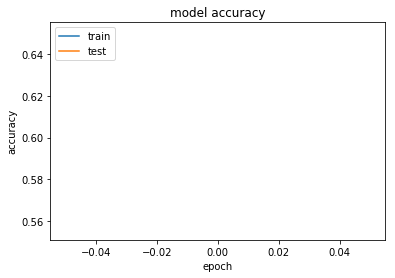

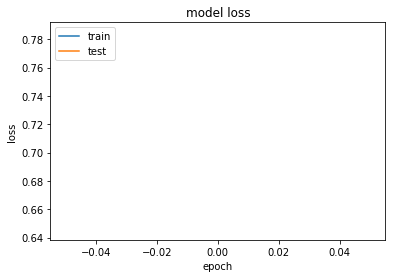

In [27]:
Baseline.validation_accuracy_loss(h_clf)

### Accuracy

In [28]:
result = { }

In [29]:
number_of_pairs = len(baseline.test_data)

#### train

In [30]:
title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, bug_train_ids, 
                                                                             number_of_pairs, 1)

y_true = sim
y_scores = model_clf.predict([title_a_seg, title_a, 
                              title_b_seg, title_b, 
                              desc_a_seg, desc_a, 
                              desc_b_seg, desc_b, 
                              info_a, info_b, 
                              topic_a, topic_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_train = accuracy_score(y_true, y_scores)
print("acc_train", acc_train)

KeyboardInterrupt: 

#### test

In [ ]:
number_of_pairs = len(baseline.test_data)

title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=True, TOPIC=True)

y_true = sim
y_scores = model_clf.predict([title_a_seg, title_a, 
                              title_b_seg, title_b, 
                              desc_a_seg, desc_a, 
                              desc_b_seg, desc_b, 
                              info_a, info_b,
                              topic_a, topic_b])

def normalize(row):
    return [1 if(r > 0.5) else 0 for r in row]

y_scores = list(map(normalize, y_scores))
# y_scores
def decode_ohe(row):
    return 0 if(row[0] == 1) else 1
y_scores = [ decode_ohe(r) for r in y_scores ]
y_true = [ decode_ohe(r) for r in y_true ]
acc_test = accuracy_score(y_true, y_scores)
print("acc_test", acc_test)

### Roc AUC/SCORE

#### train

In [ ]:
title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = batch_classification(baseline.train_data, 
                                                                             baseline.dup_sets_train, bug_train_ids, 
                                                                             number_of_pairs, 1)

y_true = sim
y_scores = model_clf.predict([title_a_seg, title_a, 
                              title_b_seg, title_b, 
                              desc_a_seg, desc_a, 
                              desc_b_seg, desc_b, 
                              info_a, info_b,
                              topic_a, topic_b])

roc_train = roc_auc_score(y_true, y_scores)
print("roc_train", roc_train)

#### test

In [ ]:
number_of_pairs = len(baseline.test_data)

title_a, title_a_seg, title_b, title_b_seg, desc_a, desc_a_seg, desc_b, desc_b_seg, info_a, info_b, topic_a, topic_b, sim = experiment.batch_classification_test(TEST_PATH, BERT=True, TOPIC=True)

y_true = sim
y_scores = model_clf.predict([title_a_seg, title_a, 
                              title_b_seg, title_b, 
                              desc_a_seg, desc_a, 
                              desc_b_seg, desc_b, 
                              info_a, info_b,
                              topic_a, topic_b])

roc_test = roc_auc_score(y_true, y_scores)
print("roc_test", roc_test)

In [ ]:
pred = np.argmax(y_scores, axis=1)
pred = pred.tolist()
pred

In [ ]:
label = np.argmax(y_true, axis=1)
label = label.tolist()
label

In [ ]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['non-duplicate', 'duplicate']), 
                      title='Confusion matrix for duplicates and non-duplicates', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}.png'.format(DOMAIN, METHOD))

In [ ]:
ax, fig = evaluation.plot_confusion_matrix(label, pred, classes=np.array(['não-duplicatas', 'duplicatas']), 
                      title='Matriz de confusão das duplicatas', normalize=True )
plt.show()
fig.savefig('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD), bbox_inches="tight")
print('resultados/classification_{}_{}_pt.png'.format(DOMAIN, METHOD))

#### Save the model

In [ ]:
experiment.save_model(model_clf, SAVE_PATH)

#### Saving the accuracy and roc/auc

In [ ]:
CLASSIFICATION_PATH = 'classification_{}.pkl'.format(METHOD)

def save_result(result):
    result = {
        'acc_train' : acc_train,
        'acc_test' : acc_test,
        'roc_train' : roc_train,
        'roc_test' : roc_test,
        'method' : METHOD
    }

    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'wb') as f:
        pickle.dump(result, f)
        
print(CLASSIFICATION_PATH)

In [ ]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

In [ ]:
try:
    with open(os.path.join(DIR, CLASSIFICATION_PATH), 'rb') as f:
        result = pickle.load(f)
    save_result(result)
except:
    save_result(result)
    
print("All saved.")

In [ ]:
print(result)